In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
import random as python_random

warnings.filterwarnings(action='ignore')


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train 데이터셋 파일 개수:",len(train_filenames))
print("test 데이터셋 파일 개수:",len(test_filenames))
print("validation 데이터셋 파일 개수",len(val_filenames))
total_train=len(train_filenames)+len(test_filenames)+len(val_filenames)

train 데이터셋 파일 개수: 5216
test 데이터셋 파일 개수: 624
validation 데이터셋 파일 개수 16


In [4]:
# tf.io.gfile.glob를 사용해서 train 폴더 안에 있는 모든 파일의 path가 리스트 형태로 담긴다.
 
print(train_filenames[:4])
type(train_filenames) 

['/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1332-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0176-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1011-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0375-0001.jpeg']


list

In [5]:
print("train 데이터셋 파일 비율: ",len(train_filenames)/total_train)
print("test 데이터셋 파일 비율: ",len(test_filenames)/total_train)
print("val 데이터셋 파일 비율: ",len(val_filenames)/total_train)

train 데이터셋 파일 비율:  0.8907103825136612
test 데이터셋 파일 비율:  0.10655737704918032
val 데이터셋 파일 비율:  0.00273224043715847


train 데이터셋의 비율은 89.07%, test 데이터셋의 비율은 10.65%, val 데이터셋의 비율은 0.27%에 해당한다. validation 데이터셋 양이 너무 적어서 train 데이터셋과 validation 데이터셋을 다시 나누자

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8) # train 데이터 사이즈

random.seed(8)  # random seed 셋팅
random.shuffle(filenames) # filenames의 순서를 섞는다

# 모아진 filenames를 8:2로 나눕니다
train_filenames = filenames[:train_size] # traindata
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


경로에 NORMAL이 포함되어 있으면 폐암 아니고, 경로에 PNEUMONIA가 포함 되어있으면 폐암.

In [7]:
print(f'Normal image path\n{filenames[0]}') 
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


train 데이터셋의 정상 폐 이미지는 1072개, 폐암 이미지는 3113개이다.

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


리스트 형태의 데이터를 tf.data.Dataset.from_tensor_slices를 사용해서 텐서플로에서 사용하는 데이터셋으로 만들어준다.

In [9]:
data=tf.data.Dataset.from_tensor_slices(train_filenames[:10]) # element가 10개인 데이터를 입력해서 
print(type(data))
print(data)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: (), types: tf.string>


data에 크기가 1인 텐서 10개가 할당되었다. 

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # training image
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()  # validatiion image
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [13]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출( 폐렴 True, 정상 False)
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

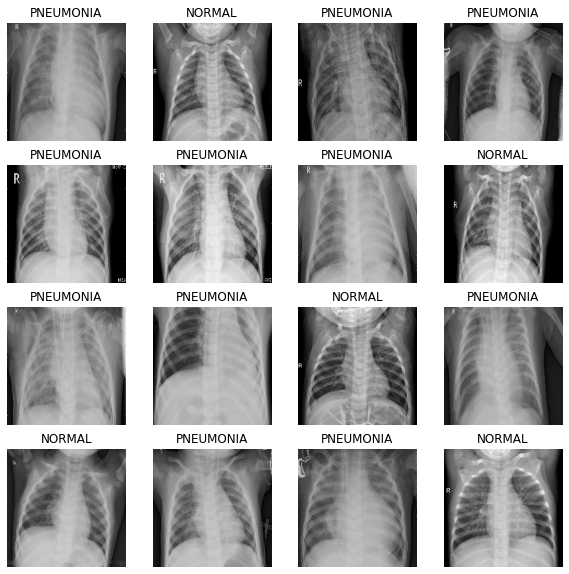

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링
- CS231에서 uniform한 분포에서 난수를 뽑아오는 것보다는 가우시안 분포 (정규분포)에서 난수를 뽑아서 초기 weight을 설정하는 것이 좋다길래 각 레이어의 kernel_initializer를 glorot_normal(xavier initializer-정규분포)로 바꿔주었다. 케라스의 kernel_initializer의 기본값은 [glorot_uniform(xavier initializer- uniform분포)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)이다. 그래서 정규분포에서 난수를 뽑아오는 설정을 추가해주어보았다.

In [24]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=1)),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [25]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [26]:
def build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(filter1, kernel_size1, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=4)),
        tf.keras.layers.Conv2D(filter2, kernel_size2, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=5)),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(dropout1),
        
        conv_block(256),
        tf.keras.layers.Dropout(dropout2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 00. learning rate 

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [33]:
EPOCHS=25

# my_callbacks = [
#    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
metrics_lr=[]
for lr in [0.01,0.001, 0.0001, 0.00001]:
    with tf.device('/GPU:0'):
        model = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=METRICS)
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,)
#            callbacks=my_callbacks)
        metrics_lr.append(history)

Epoch 1/25
261/261 [==============================] - 62s 201ms/step - loss: 0.4346 - accuracy: 0.7986 - precision: 0.9328 - recall: 0.7860 - val_loss: 0.4432 - val_accuracy: 0.8346 - val_precision: 0.8190 - val_recall: 0.9948
Epoch 2/25
261/261 [==============================] - 54s 206ms/step - loss: 0.2376 - accuracy: 0.9028 - precision: 0.9704 - recall: 0.8966 - val_loss: 3.1054 - val_accuracy: 0.3760 - val_precision: 1.0000 - val_recall: 0.1516
Epoch 3/25
261/261 [==============================] - 53s 205ms/step - loss: 0.2226 - accuracy: 0.9138 - precision: 0.9738 - recall: 0.9087 - val_loss: 0.1572 - val_accuracy: 0.9394 - val_precision: 0.9916 - val_recall: 0.9254
Epoch 4/25
261/261 [==============================] - 55s 210ms/step - loss: 0.2052 - accuracy: 0.9140 - precision: 0.9761 - recall: 0.9066 - val_loss: 0.5255 - val_accuracy: 0.8529 - val_precision: 0.9952 - val_recall: 0.8042
Epoch 5/25
261/261 [==============================] - 54s 206ms/step - loss: 0.1839 - accura

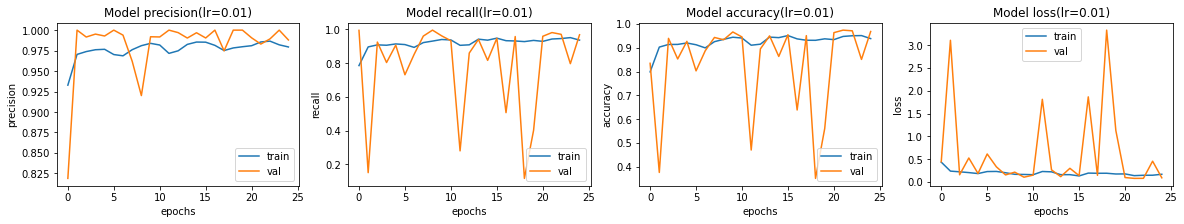

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[0]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.01)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

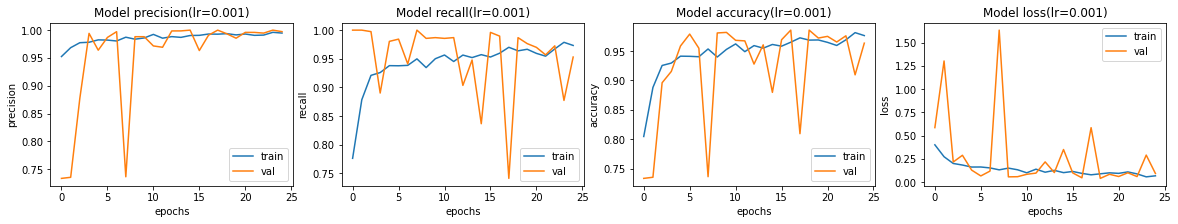

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[1]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

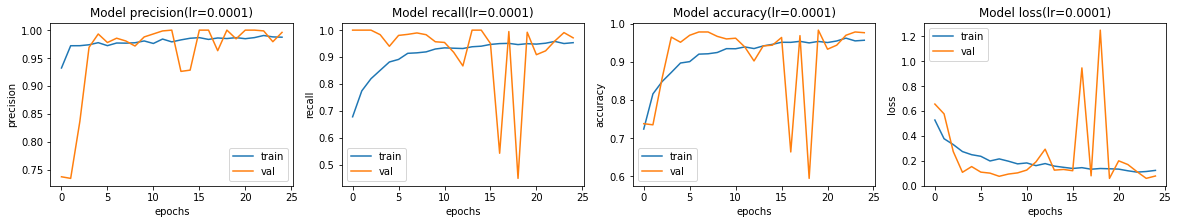

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[2]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.0001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

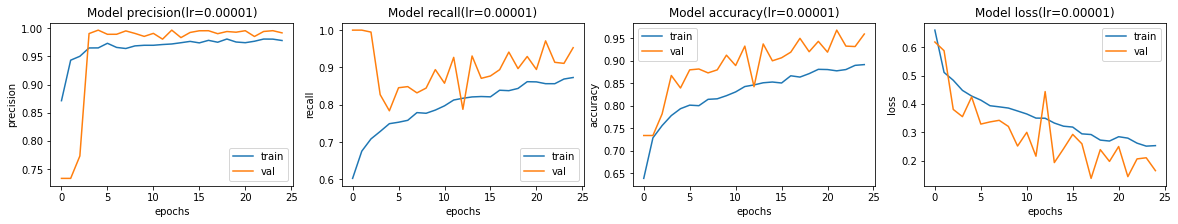

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[3]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.00001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- learning rate가 0.01, 0.001, 0.0001, 0.00001 이렇게 4가지에 대해서 돌려보았다. epoch이 증가하면 loss는 감소하고, accuracy, recall, precision은 증가한다. 
- 우리가 분류해내려고 하는 데이터는 normal이 극단적으로 많고, pneumonia가 매우 적은 데이터이다. inbalanced 데이터이기 때문에  class weight을 NORMAL은 1.95, PNEUMONIA은 0.67으로 주었다. 그래서 normal을 조금 많이 틀려도 loss가 급격하게 증가하게 되어서 4가지 그래프의 loss의 학습곡선이 들쑥날쑥한 것을 볼수 있다.  
- learning rate가 0.01과 0.001일때의 loss 그래프를 보면 epoch 초기부터 갑자기 loss가 증가하는 것을 볼수 있다. 아마도 learning rate가 너무 커서 오버슈팅일 일어나기 때문인것 같다.
- learning rate가 0.00001인 경우는 다른 learning rate에 비해서 loss가 안정적으로 줄어들지만, loss가 너무 천천히 떨어지게 되는 모습을 볼수 있다. learning rate가 지나치게 작아서 학습이 지나치게 적게 이루어진다는 확인했다.

-----------------------

- __learning rate가 0.0001일때 상대적으로 loss가 안정적으로 감소하고, accuracy와 recall, precision도 높은 편이다.__  비록 epoch이 15번 넘어가면서 2번정도 갑자기 loss가 증가하는 것을 볼수 있지만 뒤에서 check point에서 validation loss를 확인하고 피해가면 되는 정도라고 생각해서 __learning rate를 0.0001로 잡고 학습__ 을 해야겠다.

### epoch 
- 일단 50까지 쭉 돌려보고, epoch가 얼마나 많이 학습하게되면 overfitting이 일어나는지 그 구간을 찾아보자

In [40]:
#my_callbacks = [
#    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
EPOCHS=100
metrics_lr=[]
for lr in [0.0001]:
    with tf.device('/GPU:0'):
        model = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=METRICS)
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,)
#            callbacks=my_callbacks)
        metrics_lr.append(history)

Epoch 1/100
261/261 [==============================] - 59s 191ms/step - loss: 0.4900 - accuracy: 0.7708 - precision: 0.9313 - recall: 0.7469 - val_loss: 0.6078 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 49s 188ms/step - loss: 0.3195 - accuracy: 0.8630 - precision: 0.9732 - recall: 0.8392 - val_loss: 0.6433 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 49s 186ms/step - loss: 0.2850 - accuracy: 0.8853 - precision: 0.9689 - recall: 0.8738 - val_loss: 0.2122 - val_accuracy: 0.9087 - val_precision: 0.8897 - val_recall: 1.0000
Epoch 4/100
261/261 [==============================] - 49s 188ms/step - loss: 0.2426 - accuracy: 0.9066 - precision: 0.9775 - recall: 0.8949 - val_loss: 0.0954 - val_accuracy: 0.9692 - val_precision: 0.9706 - val_recall: 0.9883
Epoch 5/100
261/261 [==============================] - 50s 192ms/step - loss: 0.2195 - a

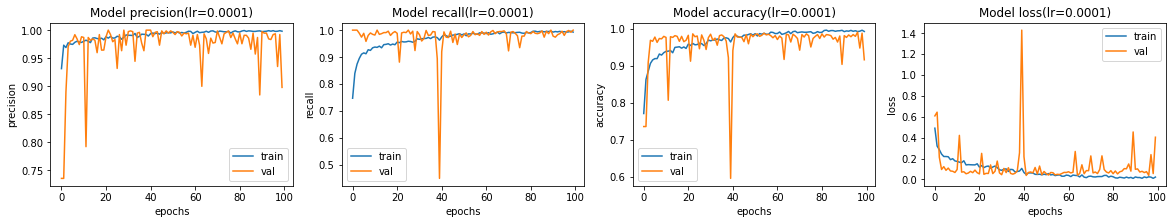

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[0]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.0001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

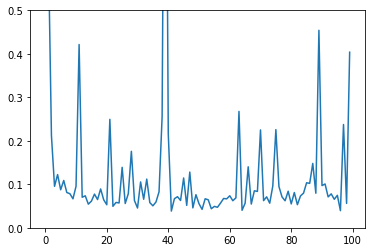

In [44]:
plt.plot(history.history["val_loss"])
plt.ylim(0,0.5)
plt.show()
print()

에포크가 42을 넘어가면서 validation loss가 다시 증가하는 것을 볼수 있다. 42 이후로는 학습하는 것이 큰 의미가 없어보이므로 42까지만 학습하기로 결정했다.

### Model1. 기본 모델 + 원본 Data 
- 기본 모델은 노드에서 주어진 기본 모델

In [ ]:
EPOCHS=50

In [ ]:
my_callbacks1= [
    tf.keras.callbacks.ModelCheckpoint(filepath='model1.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
with tf.device('/GPU:0'):
    model1 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history1 = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks1
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

루브릭에 못 미치는 정확도가 나왔다. 정확도를 높이는 방법으로 노드에서 제시했던 argumentation을 시도하였다.
### Model2. 기본모델+ Data argumentation

In [ ]:
train_ds_ag = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) 
val_ds_ag = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_ag(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_ag = prepare_for_training_ag(train_ds_ag) 
val_ds_ag = prepare_for_training_ag(val_ds_ag)


In [ ]:
my_callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model2.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

with tf.device('/GPU:0'):
    model2 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history2 = model2.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks2
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

### Model3. 원본 데이터에 filter=20, dropout =0.5

filter1=20, kernel_size1=3, filter2=20, kernel_size2=3, dropout1=0.5, dropout2=0.5 
필터 개수를 20개로 늘리고 dropout rate를 0.5로 늘렸다

In [ ]:
my_callbacks3 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model3.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

with tf.device('/GPU:0'):
    model3 = build_model(filter1=20, kernel_size1=3, filter2=20, kernel_size2=3, dropout1=0.5, dropout2=0.5)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks3
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Model4. data  argumentation한 데이터에 filter 20개, dropout 0.5

In [ ]:
my_callbacks4 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]


with tf.device('/GPU:0'):
    model4 = build_model(filter1=20, kernel_size1=3, filter2=20, kernel_size2=3, dropout1=0.5, dropout2=0.5)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:

with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks4)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Model5.  (filter 16개, dropout 0.5)+data  argumentation

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [ ]:
my_callbacks5 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model5.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

with tf.device('/GPU:0'):
    model5 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.5, dropout2=0.5)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model5.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history5 = model5.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks5)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history5.history[met])
    ax[i].plot(history5.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Model6. (filter 16개, dropout 0.5) + 원본 데이터

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [ ]:
my_callbacks6 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model6.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]


with tf.device('/GPU:0'):
    model6 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.5, dropout2=0.5)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model6.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history6 = model6.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks6)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history6.history[met])
    ax[i].plot(history6.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 최종 선택한 모델을 test set에 돌려볼것

In [ ]:
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
loss, accuracy, precision, recall = model5.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
loss, accuracy, precision, recall = model6.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')